전이학습

In [1]:
import tensorflow as tf
from tensorflow import keras

conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet", 
    include_top=False, 
    input_shape=(180, 180, 3))

58892288/58889256 [==============================] - 0s 0us/step


In [2]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 180, 180, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 180, 180, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 90, 90, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 90, 90, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 90, 90, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 45, 45, 128)       0     

데이터 불러오기

- Kaggle dogs-vs-cats

In [3]:
from google.colab import files 
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hongjoolee","key":"78a7f6d35e6fd7d34aab00808043355c"}'}

In [5]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/ 
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle competitions download -c dogs-vs-cats 

 97% 527M/543M [00:02<00:00, 193MB/s]
100% 543M/543M [00:02<00:00, 190MB/s]
  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 77.6MB/s]
 96% 259M/271M [00:01<00:00, 192MB/s]
100% 271M/271M [00:01<00:00, 197MB/s]


In [7]:
!unzip -qq train.zip

In [8]:
import os, shutil, pathlib

original_dir = pathlib.Path("train") 
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):

  for category in ("cat", "dog"):
    dir = new_base_dir / subset_name / category 
    os.makedirs(dir) 
    fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)] 
    for fname in fnames:
        shutil.copyfile(src=original_dir / fname, dst=dir / fname)

make_subset("train", start_index=0, end_index=1000) 
make_subset("validation", start_index=1000, end_index=1500) 
make_subset("test", start_index=1500, end_index=2500)

In [9]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_dataset = image_dataset_from_directory( 
    new_base_dir / "train", 
    image_size=(180, 180), 
    batch_size=32) 
validation_dataset = image_dataset_from_directory( 
    new_base_dir / "validation", 
    image_size=(180, 180), 
    batch_size=32) 
test_dataset = image_dataset_from_directory( 
    new_base_dir / "test", 
    image_size=(180, 180), 
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


데이터 증강 없는 특성 추출

In [10]:
import numpy as np

def get_features_and_labels(dataset):
  all_features = [] 
  all_labels = [] 
  for images, labels in dataset:
    preprocessed_images = keras.applications.vgg16.preprocess_input(images)
    features = conv_base.predict(preprocessed_images)
    all_features.append(features)
    all_labels.append(labels) 
  return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels = get_features_and_labels(train_dataset) 
val_features, val_labels = get_features_and_labels(validation_dataset) 
test_features, test_labels = get_features_and_labels(test_dataset)

In [11]:
train_features.shape

(2000, 5, 5, 512)

In [12]:
from tensorflow.keras import layers 

inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs) 
x = layers.Dense(256)(x) 
x = layers.Dropout(0.5)(x) 
outputs = layers.Dense(1, activation="sigmoid")(x) 
model = keras.Model(inputs, outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [ 
  keras.callbacks.ModelCheckpoint(
    filepath="feature_extraction.h5",
    save_best_only=True,
    monitor="val_loss")
] 

history = model.fit(
  train_features, train_labels, 
  epochs=20, 
  validation_data=(val_features, val_labels), 
  callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 1s 9ms/step - loss: 15.0271 - accuracy: 0.9200 - val_loss: 3.9896 - val_accuracy: 0.9660
Epoch 2/20
63/63 [==============================] - 0s 8ms/step - loss: 4.3539 - accuracy: 0.9760 - val_loss: 5.2450 - val_accuracy: 0.9680
Epoch 3/20
63/63 [==============================] - 0s 6ms/step - loss: 2.3194 - accuracy: 0.9855 - val_loss: 2.7804 - val_accuracy: 0.9760
Epoch 4/20
63/63 [==============================] - 0s 7ms/step - loss: 1.4484 - accuracy: 0.9890 - val_loss: 4.1247 - val_accuracy: 0.9690
Epoch 5/20
63/63 [==============================] - 0s 8ms/step - loss: 0.8965 - accuracy: 0.9945 - val_loss: 3.5228 - val_accuracy: 0.9740
Epoch 6/20
63/63 [==============================] - 0s 7ms/step - loss: 0.6825 - accuracy: 0.9945 - val_loss: 3.6537 - val_accuracy: 0.9780
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 0.6812 - accuracy: 0.9925 - val_loss: 7.5287 - val_accuracy: 0.9660
Epoch 8/20
63/63 [=

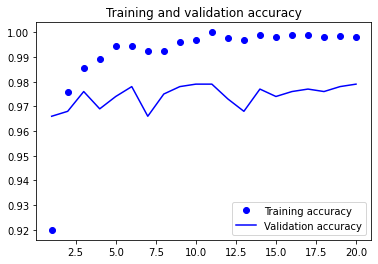

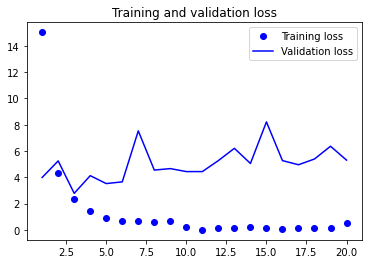

In [13]:
import matplotlib.pyplot as plt

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"] 
loss = history.history["loss"] 
val_loss = history.history["val_loss"] 
epochs = range(1, len(acc) + 1) 
plt.plot(epochs, acc, "bo", label="Training accuracy") 
plt.plot(epochs, val_acc, "b", label="Validation accuracy") 
plt.title("Training and validation accuracy") 
plt.legend() 
plt.figure() 
plt.plot(epochs, loss, "bo", label="Training loss") 
plt.plot(epochs, val_loss, "b", label="Validation loss") 
plt.title("Training and validation loss") 
plt.legend() 
plt.show()

In [15]:
test_model = keras.models.load_model("feature_extraction.h5") 
test_loss, test_acc = test_model.evaluate(test_features, test_labels) 
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 0s 3ms/step - loss: 4.5151 - accuracy: 0.9745
Test accuracy: 0.975


데이터 증강과 특성 추출

In [16]:
conv_base = keras.applications.vgg16.VGG16( 
    weights="imagenet", 
    include_top=False) 
conv_base.trainable = False

In [17]:
data_augmentation = keras.Sequential( 
    [ layers.experimental.preprocessing.RandomFlip("horizontal"), 
     layers.experimental.preprocessing.RandomRotation(0.1), 
     layers.experimental.preprocessing.RandomZoom(0.2), 
     ] 
)

inputs = keras.Input(shape=(180, 180, 3)) 
x = data_augmentation(inputs) 
x = conv_base(x) 
x = layers.Flatten()(x) 
x = layers.Dense(256)(x) 
x = layers.Dropout(0.5)(x) 
outputs = layers.Dense(1, activation="sigmoid")(x) 
model = keras.Model(inputs, outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [18]:
callbacks = [ keras.callbacks.ModelCheckpoint(
    filepath="feature_extraction_with_data_augmentation.h5",
    save_best_only=True,
    monitor="val_loss")
] 

history = model.fit(
    train_dataset, 
    epochs=50, 
    validation_data=validation_dataset, 
    callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 13s 188ms/step - loss: 27.8392 - accuracy: 0.8555 - val_loss: 49.2543 - val_accuracy: 0.8000
Epoch 2/50
63/63 [==============================] - 12s 189ms/step - loss: 11.6380 - accuracy: 0.9090 - val_loss: 13.8817 - val_accuracy: 0.9320
Epoch 3/50
63/63 [==============================] - 12s 187ms/step - loss: 8.3971 - accuracy: 0.9325 - val_loss: 7.9438 - val_accuracy: 0.9510
Epoch 4/50
63/63 [==============================] - 12s 185ms/step - loss: 9.2687 - accuracy: 0.9265 - val_loss: 6.3077 - val_accuracy: 0.9570
Epoch 5/50
63/63 [==============================] - 12s 182ms/step - loss: 7.6155 - accuracy: 0.9310 - val_loss: 6.9041 - val_accuracy: 0.9540
Epoch 6/50
63/63 [==============================] - 12s 181ms/step - loss: 5.8344 - accuracy: 0.9400 - val_loss: 8.6716 - val_accuracy: 0.9460
Epoch 7/50
63/63 [==============================] - 12s 182ms/step - loss: 5.1610 - accuracy: 0.9460 - val_loss: 5.1912 - val_accuracy: 0.

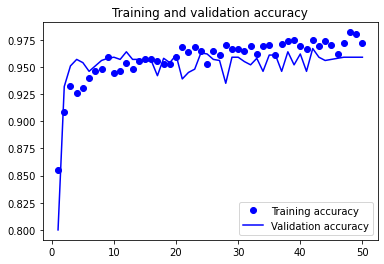

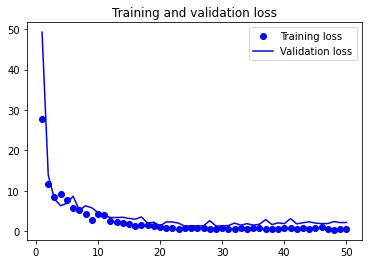

In [19]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"] 
loss = history.history["loss"] 
val_loss = history.history["val_loss"] 
epochs = range(1, len(acc) + 1) 
plt.plot(epochs, acc, "bo", label="Training accuracy") 
plt.plot(epochs, val_acc, "b", label="Validation accuracy") 
plt.title("Training and validation accuracy") 
plt.legend() 
plt.figure() 
plt.plot(epochs, loss, "bo", label="Training loss") 
plt.plot(epochs, val_loss, "b", label="Validation loss") 
plt.title("Training and validation loss") 
plt.legend() 
plt.show()

In [20]:
test_model = keras.models.load_model("feature_extraction_with_data_augmentation.h5") 
test_loss, test_acc = test_model.evaluate(test_dataset) 
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 8s 117ms/step - loss: 1.1413 - accuracy: 0.9655
Test accuracy: 0.965


미세 조정

- 데이터 증강과 특성 추출 실습에서 이어짐

In [21]:
conv_base.trainable = True 

for layer in conv_base.layers[:-4]:
  layer.trainable = False

In [22]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5), 
              metrics=["accuracy"])

callbacks = [ 
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.h5", 
        save_best_only=True, monitor="val_loss") 
] 

history = model.fit( 
    train_dataset, 
    epochs=30, 
    validation_data=validation_dataset, 
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 16s 211ms/step - loss: 0.3522 - accuracy: 0.9815 - val_loss: 2.0829 - val_accuracy: 0.9640
Epoch 2/30
63/63 [==============================] - 13s 202ms/step - loss: 0.4625 - accuracy: 0.9795 - val_loss: 2.2119 - val_accuracy: 0.9590
Epoch 3/30
63/63 [==============================] - 13s 202ms/step - loss: 0.3630 - accuracy: 0.9840 - val_loss: 2.0956 - val_accuracy: 0.9580
Epoch 4/30
63/63 [==============================] - 13s 206ms/step - loss: 0.4383 - accuracy: 0.9800 - val_loss: 3.5556 - val_accuracy: 0.9440
Epoch 5/30
63/63 [==============================] - 13s 209ms/step - loss: 0.3831 - accuracy: 0.9820 - val_loss: 1.8299 - val_accuracy: 0.9600
Epoch 6/30
63/63 [==============================] - 14s 213ms/step - loss: 0.4147 - accuracy: 0.9805 - val_loss: 1.6486 - val_accuracy: 0.9580
Epoch 7/30
63/63 [==============================] - 13s 202ms/step - loss: 0.3477 - accuracy: 0.9810 - val_loss: 1.6089 - val_accuracy: 0.9620

In [23]:
model = keras.models.load_model("fine_tuning.h5") 
test_loss, test_acc = model.evaluate(test_dataset) 
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 8s 115ms/step - loss: 1.1471 - accuracy: 0.9735
Test accuracy: 0.974


합성곱 신경망 학습 시각화

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
import tensorflow as tf
from tensorflow import keras

model = keras.models.load_model('/content/drive/My Drive/convnet_from_scratch_with_augmentation.h5')
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 87, 87, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 43, 43, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 41, 41, 128)       7385

테스트용 고양이 이미지 다운로드 

In [4]:
from tensorflow import keras 
import numpy as np

img_path = keras.utils.get_file(
  fname="cat.jpg", 
  origin="https://img-datasets.s3.amazonaws.com/cat.jpg")

def get_img_array(img_path, target_size):
  img = keras.preprocessing.image.load_img( img_path, target_size=target_size) 
  array = keras.preprocessing.image.img_to_array(img) 
  array = np.expand_dims(array, axis=0) 
  return array
  
img_tensor = get_img_array(img_path, target_size=(180, 180))

81920/80329 [==============================] - 0s 0us/step


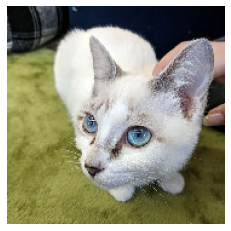

In [5]:
import matplotlib.pyplot as plt 

plt.axis("off") 
plt.imshow(img_tensor[0].astype("uint8")) 
plt.show()

In [6]:
from tensorflow.keras import layers

layer_outputs = [] 
layer_names = [] 

for layer in model.layers:
  if isinstance(layer, (layers.Conv2D, layers.MaxPooling2D)):
    layer_outputs.append(layer.output)
    layer_names.append(layer.name) 

activation_model = keras.Model(inputs=model.input, outputs=layer_outputs)

In [7]:
activations = activation_model.predict(img_tensor)

In [8]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 178, 178, 32)


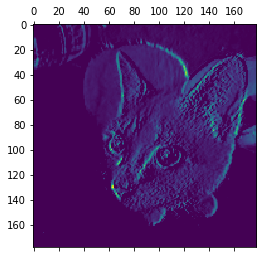

In [9]:
import matplotlib.pyplot as plt 
plt.matshow(first_layer_activation[0, :, :, 5], cmap="viridis")

In [11]:
images_per_row = 16 

for layer_name, layer_activation in zip(layer_names, activations):
  n_features = layer_activation.shape[-1]
  size = layer_activation.shape[1]
  n_cols = n_features // images_per_row 
  display_grid = np.zeros(((size + 1) * n_cols - 1, images_per_row * (size + 1) - 1)) 
  
  for col in range(n_cols):
    for row in range(images_per_row):
      channel_index = col * images_per_row + row
      channel_image = layer_activation[0, :, :, channel_index].copy()

      if channel_image.sum() != 0:
        channel_image -= channel_image.mean() 
        channel_image /= channel_image.std() 
        channel_image *= 64 
        channel_image += 128
        channel_image = np.clip(channel_image, 0, 255).astype("uint8")
      display_grid[ col * (size + 1): (col + 1) * size + col, row * (size + 1) : (row + 1) * size + row] = channel_image 
  scale = 1. / size 
  plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0])) 
  plt.title(layer_name) 
  plt.grid(False) 
  plt.axis("off")
  plt.imshow(display_grid, aspect="auto", cmap="viridis")

Output hidden; open in https://colab.research.google.com to view.

합성곱 신경망 필터를 시각화


In [12]:
model = keras.applications.xception.Xception( 
    weights="imagenet", 
    include_top=False)

83689472/83683744 [==============================] - 1s 0us/step


In [13]:
for layer in model.layers:
  if isinstance(layer, (keras.layers.Conv2D, keras.layers.SeparableConv2D)):
    print(layer.name)

block1_conv1
block1_conv2
block2_sepconv1
block2_sepconv2
conv2d
block3_sepconv1
block3_sepconv2
conv2d_1
block4_sepconv1
block4_sepconv2
conv2d_2
block5_sepconv1
block5_sepconv2
block5_sepconv3
block6_sepconv1
block6_sepconv2
block6_sepconv3
block7_sepconv1
block7_sepconv2
block7_sepconv3
block8_sepconv1
block8_sepconv2
block8_sepconv3
block9_sepconv1
block9_sepconv2
block9_sepconv3
block10_sepconv1
block10_sepconv2
block10_sepconv3
block11_sepconv1
block11_sepconv2
block11_sepconv3
block12_sepconv1
block12_sepconv2
block12_sepconv3
block13_sepconv1
block13_sepconv2
conv2d_3
block14_sepconv1
block14_sepconv2


In [14]:
layer_name = "block3_sepconv1" 
layer = model.get_layer(name=layer_name) 
feature_extractor = keras.Model(inputs=model.input, outputs=layer.output)

In [15]:
activation = feature_extractor( keras.applications.xception.preprocess_input(img_tensor) )

In [16]:
import tensorflow as tf

def compute_loss(image, filter_index):
  activation = feature_extractor(image)
  filter_activation = activation[:, 2:-2, 2:-2, filter_index]
  return tf.reduce_mean(filter_activation)

In [17]:
@tf.function 

def gradient_ascent_step(image, filter_index, learning_rate):
  with tf.GradientTape() as tape:
    tape.watch(image) 
    loss = compute_loss(image, filter_index) 
  grads = tape.gradient(loss, image) 
  grads = tf.math.l2_normalize(grads) 
  image += learning_rate * grads 
  return image

In [20]:
img_width = 200 
img_height = 200

def generate_filter_pattern(filter_index):
  iterations = 30 
  learning_rate = 10.
  image = tf.random.uniform(
    minval=0.4,
    maxval=0.6,
    shape=(1, img_width, img_height, 3)) 
  for i in range(iterations):
    image = gradient_ascent_step(image, filter_index, learning_rate) 
  return image[0].numpy()

In [21]:
def deprocess_image(image):
  image -= image.mean() 
  image /= image.std() 
  image *= 64 
  image += 128 
  image = np.clip(image, 0, 255).astype("uint8") 
  image = image[25:-25, 25:-25, :] 
  return image

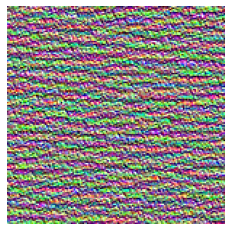

In [22]:
plt.axis("off")
plt.imshow(deprocess_image(generate_filter_pattern(filter_index=2)))

클래스 활성화에 대한 히트맵 시각화

In [23]:
model = keras.applications.xception.Xception(weights="imagenet")

91889664/91884032 [==============================] - 1s 0us/step


In [24]:
img_path = keras.utils.get_file(
  fname="elephant.jpg", 
  origin="https://img-datasets.s3.amazonaws.com/elephant.jpg")

def get_img_array(img_path, target_size):
  img = keras.preprocessing.image.load_img(img_path, target_size=target_size) 
  array = keras.preprocessing.image.img_to_array(img) 
  array = np.expand_dims(array, axis=0) 
  array = keras.applications.xception.preprocess_input(array) 
  return array

img_array = get_img_array(img_path, target_size=(299, 299))

737280/733657 [==============================] - 0s 0us/step


In [25]:
preds = model.predict(img_array)
print(keras.applications.xception.decode_predictions(preds, top=3)[0])

40960/35363 [==================================] - 0s 0us/step
[('n02504458', 'African_elephant', 0.8699264), ('n01871265', 'tusker', 0.076968774), ('n02504013', 'Indian_elephant', 0.023537323)]


- 386: African elephant class

In [26]:
np.argmax(preds[0])

386

Grad-CAM

In [27]:
last_conv_layer_name = "block14_sepconv2_act" 
classifier_layer_names = [
                          "avg_pool",
                          "predictions", ] 
                
last_conv_layer = model.get_layer(last_conv_layer_name) 
last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

In [28]:
classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:]) 
x = classifier_input 
for layer_name in classifier_layer_names:
  x = model.get_layer(layer_name)(x) 
  
classifier_model = keras.Model(classifier_input, x)

In [29]:
import tensorflow as tf

with tf.GradientTape() as tape:
  last_conv_layer_output = last_conv_layer_model(img_array) 
  tape.watch(last_conv_layer_output) 
  preds = classifier_model(last_conv_layer_output) 
  top_pred_index = tf.argmax(preds[0]) 
  top_class_channel = preds[:, top_pred_index]

grads = tape.gradient(top_class_channel, last_conv_layer_output)

In [30]:
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy() 
last_conv_layer_output = last_conv_layer_output.numpy()[0] 
for i in range(pooled_grads.shape[-1]):
  last_conv_layer_output[:, :, i] *= pooled_grads[i] 

heatmap = np.mean(last_conv_layer_output, axis=-1)

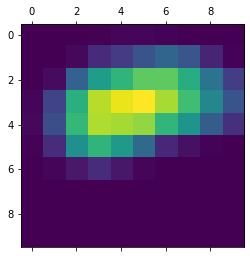

In [31]:
heatmap = np.maximum(heatmap, 0) 
heatmap /= np.max(heatmap) 
plt.matshow(heatmap)

In [33]:
import matplotlib.cm as cm

img = keras.preprocessing.image.load_img(img_path) 
img = keras.preprocessing.image.img_to_array(img)

heatmap = np.uint8(255 * heatmap)

jet = cm.get_cmap("jet") 
jet_colors = jet(np.arange(256))[:, :3] 
jet_heatmap = jet_colors[heatmap]

jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap) 
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0])) 
jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

superimposed_img = jet_heatmap * 0.4 + img 
superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

save_path = '/content/drive/My Drive/elephant_cam.jpg'
superimposed_img.save(save_path)